# Queston 01

In [ ]:
# Imports
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load the image in grayscale
img = Image.open('emma.jpg').convert("L")
input_pixels = np.array(img)

In [ ]:
transformed_pixels = np.zeros_like(input_pixels, dtype=np.uint8)

In [ ]:
# Input intensity between 0 and 49
mask_low_range = input_pixels < 50
transformed_pixels[mask_low_range] = input_pixels[mask_low_range]

In [ ]:
# Input intensity between 50 and 149
mask_mid_range = (input_pixels >= 50) & (input_pixels < 150)
transformed_pixels[mask_mid_range] = (
    100 + (input_pixels[mask_mid_range] - 50) * (155 // 100)
)

In [ ]:
# Input intensity between 150 and 255
mask_high_range = input_pixels >= 150
transformed_pixels[mask_high_range] = input_pixels[mask_high_range]

In [ ]:
transformed_image = Image.fromarray(transformed_pixels)

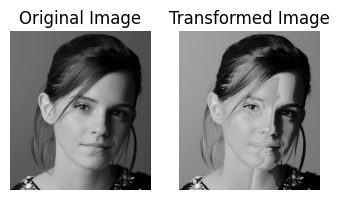

In [ ]:
# Display original and transformed images side by side
plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.imshow(input_pixels, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(transformed_pixels, cmap="gray")
plt.title("Transformed Image")
plt.axis("off")

plt.show()

# Question 02

In [ ]:
# Imports
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Helper functions

def estimate_non_background_percentiles(image_uint8, background_limit=5):
    all_pixels = image_uint8.ravel()
    non_background = all_pixels[all_pixels > background_limit]
    return np.percentile(non_background, [10, 35, 50, 60, 80, 90])

# Building window lookup table
def build_window_lut(window_start, window_end,
                     output_min=0, output_max=255,
                     outside_slope_fraction=0.05):
    x = np.arange(256, dtype=np.float32)
    inside_slope = (output_max - output_min) / max(window_end - window_start, 1e-6)
    outside_slope = outside_slope_fraction * inside_slope

    lut = np.zeros_like(x)
    below = x < window_start
    inside = (x >= window_start) & (x <= window_end)
    above = x > window_end

    lut[below]  = output_min + outside_slope * (x[below] - window_start)
    lut[inside] = output_min + inside_slope   * (x[inside] - window_start)
    lut[above]  = output_max + outside_slope * (x[above] - window_end)

    return np.clip(lut, 0, 255).astype(np.uint8)

# Applying Lookup table
def apply_lookup_table(image_uint8, lut):
    return lut[image_uint8]

In [ ]:
# Loading the image
image_path = "brain_proton_density_slice.png"
brain_image = Image.open(image_path).convert("L")
brain_pixels = np.array(brain_image)

# Estimate intensity ranges
p10, p35, p50, p60, p80, p90 = estimate_non_background_percentiles(brain_pixels)

# White matter = darker band, Gray matter = brighter band
white_matter_window = (int(p35), int(p60))
gray_matter_window  = (int(p60), int(p80))

# Build transforms
white_matter_lut = build_window_lut(*white_matter_window)
gray_matter_lut  = build_window_lut(*gray_matter_window)

# Apply transforms
white_matter_enhanced = apply_lookup_table(brain_pixels, white_matter_lut)
gray_matter_enhanced  = apply_lookup_table(brain_pixels, gray_matter_lut)

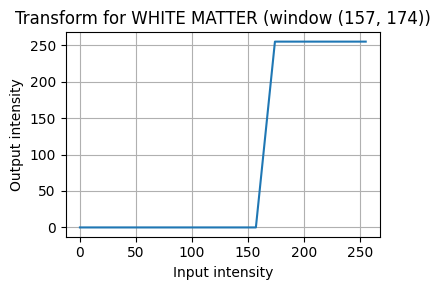

In [ ]:
# transform curve for WHITE MATTER
x = np.arange(256)
plt.figure(figsize=(4,3))
plt.plot(x, white_matter_lut)
plt.title(f"Transform for WHITE MATTER (window {white_matter_window})")
plt.xlabel("Input intensity"); plt.ylabel("Output intensity"); plt.grid(True)
plt.tight_layout(); plt.show()

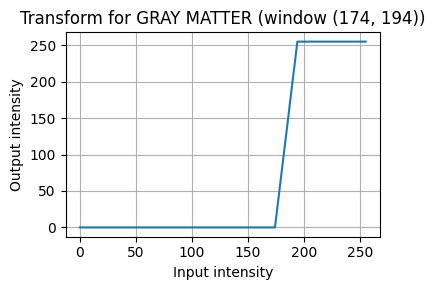

In [ ]:
# transform curve for GRAY MATTER
plt.figure(figsize=(4,3))
plt.plot(x, gray_matter_lut)
plt.title(f"Transform for GRAY MATTER (window {gray_matter_window})")
plt.xlabel("Input intensity"); plt.ylabel("Output intensity"); plt.grid(True)
plt.tight_layout(); plt.show()

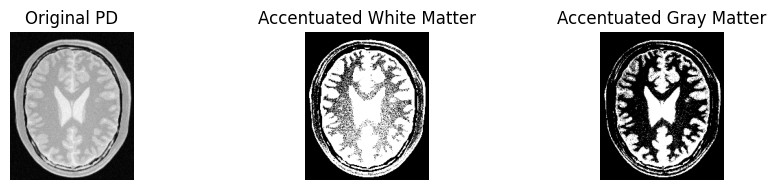

In [ ]:
# Show the transformed images

plt.figure(figsize=(10,2))
plt.subplot(1,3,1); plt.imshow(brain_pixels, cmap="gray"); plt.title("Original PD"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(white_matter_enhanced, cmap="gray"); plt.title("Accentuated White Matter"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(gray_matter_enhanced,  cmap="gray"); plt.title("Accentuated Gray Matter");  plt.axis("off")
plt.tight_layout(); plt.show()

# Question 03

In [ ]:
# Installing opencv

!pip install opencv-python

In [ ]:
# Imports

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Configuration

input_image_path  = "highlights_and_shadows.jpg"
output_image_path = "image_L_gamma_0p8.jpg"
gamma_value = 1.0

In [ ]:
# Load image (BGR in OpenCV)

bgr_image = cv2.imread(input_image_path)
if bgr_image is None:
    raise FileNotFoundError(f"Could not read {input_image_path}")

In [ ]:
# BGR → LAB (OpenCV: L 0–255; a/b centered at 128)

lab_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2LAB)
L_channel, a_channel, b_channel = cv2.split(lab_image)  # uint8

In [ ]:
# Apply gamma to L only
L_normalized = L_channel.astype(np.float32) / 255.0         # [0,1]
L_gamma_corrected = (L_normalized ** gamma_value) * 255.0   # back to [0,255]
L_gamma_u8 = np.clip(L_gamma_corrected, 0, 255).astype(np.uint8)

In [ ]:
# Reassemble LAB and convert back to BGR
lab_corrected = cv2.merge([L_gamma_u8, a_channel, b_channel])
bgr_corrected = cv2.cvtColor(lab_corrected, cv2.COLOR_LAB2BGR)

In [ ]:
# Save gamma corrected image

cv2.imwrite(output_image_path, bgr_corrected)

True

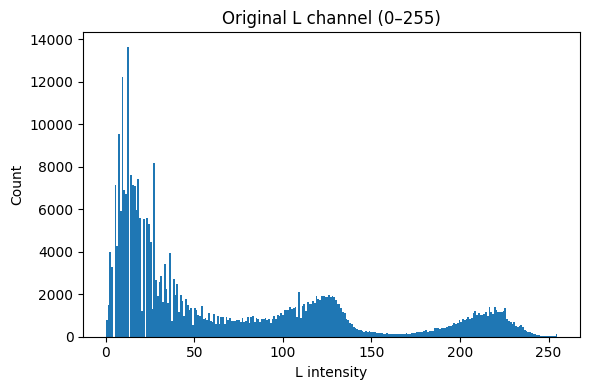

In [ ]:
# Histogram for Original

plt.figure(figsize=(6,4))
plt.hist(L_channel.ravel(), bins=256, range=(0,255))
plt.title("Original L channel (0–255)")
plt.xlabel("L intensity"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

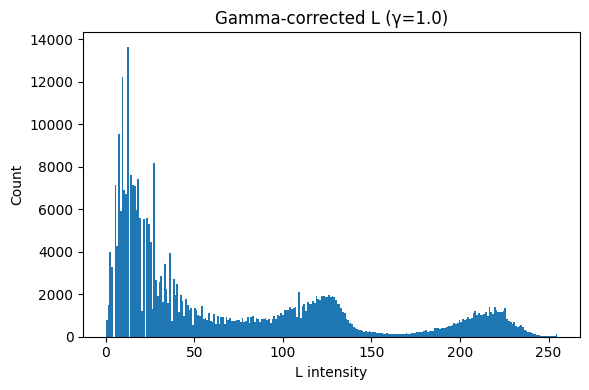

In [ ]:
# Histogram for corrected

plt.figure(figsize=(6,4))
plt.hist(L_gamma_u8.ravel(), bins=256, range=(0,255))
plt.title(f"Gamma-corrected L (γ={gamma_value})")
plt.xlabel("L intensity"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

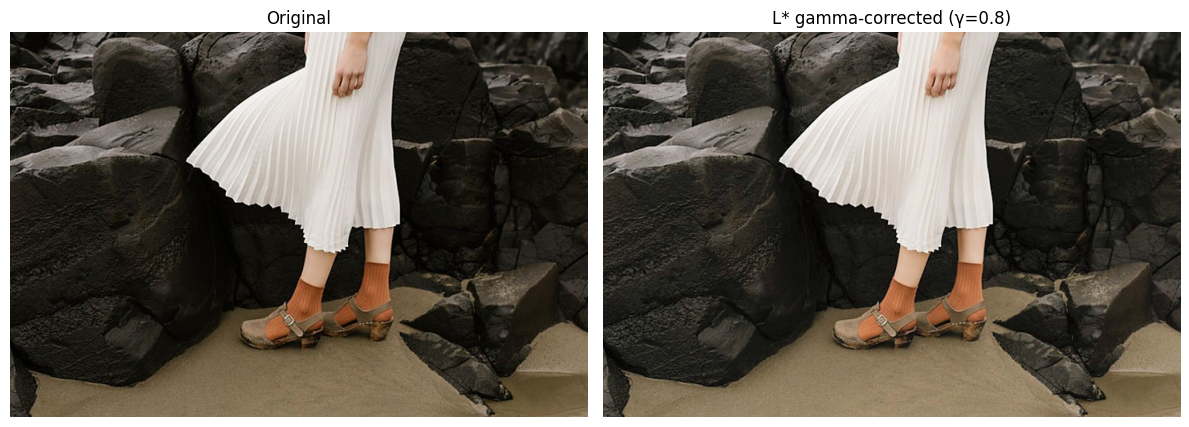

In [ ]:
# Plot Original and Corrected side by side

rgb_original  = cv2.cvtColor(bgr_image,     cv2.COLOR_BGR2RGB)
rgb_corrected = cv2.cvtColor(bgr_corrected, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(rgb_original)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(rgb_corrected);
plt.title(f"L* gamma-corrected (γ={gamma_value})")
plt.axis("off")
plt.tight_layout()
plt.show()

# Question 04

In [ ]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Image config
image_path = "spider.png"
output_image = "spider_vibrance_enhanced.png"
vibrance_strength  = 0.65
gaussian_sigma = 70.0

In [ ]:
bgr_image = cv2.imread(image_path)
if bgr_image is None:
    raise FileNotFoundError(f"Could not read {image_path}")

# HSV ranges: H ∈ [0,179], S ∈ [0,255], V ∈ [0,255]
hsv_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)

# (a) Split the image into H, S, V planes
hue_channel, saturation_channel, value_channel = cv2.split(hsv_image)  # each is uint8

In [ ]:
# Applying vibrance transform to Saturation only
saturation_float = saturation_channel.astype(np.float32)

# Gaussian “bump” centered at 128 (mid-saturation)
gaussian_bump = 128.0 * np.exp(-((saturation_float - 128.0) ** 2) / (2.0 * gaussian_sigma * gaussian_sigma))

# Apply the intensity transform ONLY to the Saturation plane
# f(x) = min( x + a * bump, 255 )
saturation_enhanced = np.clip(
    saturation_float + vibrance_strength * gaussian_bump,
    0, 255
).astype(np.uint8)


In [ ]:
# Recombine channels and convert back to BGR
hsv_enhanced = cv2.merge([hue_channel, saturation_enhanced, value_channel])
bgr_enhanced = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2BGR)

# Save result
cv2.imwrite(output_image, bgr_enhanced)

# Adjust 'a' for pleasing output and REPORT it
print(f"[REPORT] Chosen vibrance strength a = {vibrance_strength}")

[REPORT] Chosen vibrance strength a = 0.65


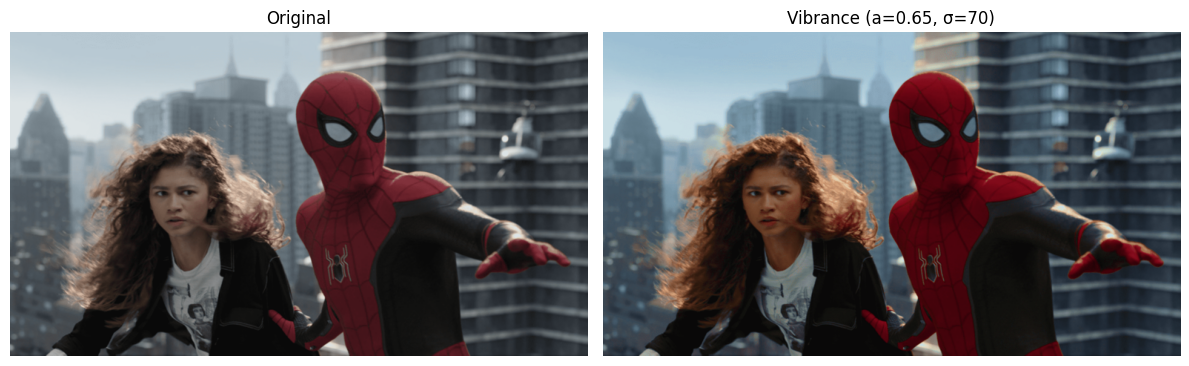

In [ ]:
# Display the original image and the vibrance-enhanced image
rgb_original  = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
rgb_enhanced  = cv2.cvtColor(bgr_enhanced, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb_original)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(rgb_enhanced);
plt.title(f"Vibrance (a={vibrance_strength}, σ={int(gaussian_sigma)})");
plt.axis("off")
plt.tight_layout()
plt.show()

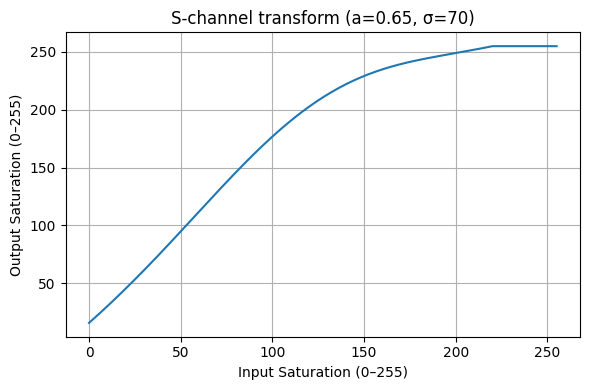

In [ ]:
# Display the intensity transformation curve f(x) used on the S channel
input_s_values = np.arange(256, dtype=np.float32)
bump_curve     = 128.0 * np.exp(-((input_s_values - 128.0) ** 2) / (2.0 * gaussian_sigma * gaussian_sigma))
output_s_values = np.minimum(input_s_values + vibrance_strength * bump_curve, 255.0)

plt.figure(figsize=(6, 4))
plt.plot(input_s_values, output_s_values)
plt.title(f"S-channel transform (a={vibrance_strength}, σ={int(gaussian_sigma)})")
plt.xlabel("Input Saturation (0–255)")
plt.ylabel("Output Saturation (0–255)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Question 05

In [ ]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Image Config
image_path = "jeniffer.jpg"
output_image = "jenniffer_foreground_hist_e.jpg"

In [ ]:
# Load Image
bgr_image = cv2.imread(image_path)
if bgr_image is None:
    raise FileNotFoundError(f"Cannot read image {image_path}")

# (a) Split the image to HSV
# HSV ranges: H ∈ [0,179], S ∈ [0,255], V ∈ [0,255]
hsv_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)
hue_plane, saturation_plane, value_plane = cv2.split(hsv_image)

In [ ]:
# (b) Foreground mask
# Otsu on Saturation: subject typically has higher S than background
otsu_threshold_value, foreground_mask = cv2.threshold(
    saturation_plane, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
foreground_mask = cv2.morphologyEx(foreground_mask, cv2.MORPH_CLOSE, kernel, 1)
foreground_mask = cv2.morphologyEx(foreground_mask, cv2.MORPH_OPEN,  kernel, 1)

In [ ]:
# (c) Foreground histogram
# Compute histogram of Value channel ONLY where mask==255
foreground_hist_counts = cv2.calcHist(
    images=[value_plane], channels=[0], mask=foreground_mask, histSize=[256], ranges=[0, 256]
).flatten().astype(np.int64)

In [ ]:
# (d, e) CDF → LUT
foreground_cdf = np.cumsum(foreground_hist_counts).astype(np.float64)
if foreground_cdf[-1] > 0:
    cdf_min = foreground_cdf[foreground_cdf > 0][0]
    lut = np.floor((foreground_cdf - cdf_min) * 255.0 / (foreground_cdf[-1] - cdf_min + 1e-9))
else:
    lut = np.zeros(256)
lookup_table = np.clip(lut, 0, 255).astype(np.uint8)

In [ ]:
# Equalize foreground ONLY on Value plane
equalized_value_plane = value_plane.copy()
equalized_value_plane[foreground_mask == 255] = lookup_table[value_plane[foreground_mask == 255]]

In [ ]:
# (f) Recombine & save
hsv_equalized = cv2.merge([hue_plane, saturation_plane, equalized_value_plane])
bgr_result = cv2.cvtColor(hsv_equalized, cv2.COLOR_HSV2BGR)

# Save Result Image
cv2.imwrite(output_image, bgr_result)

True

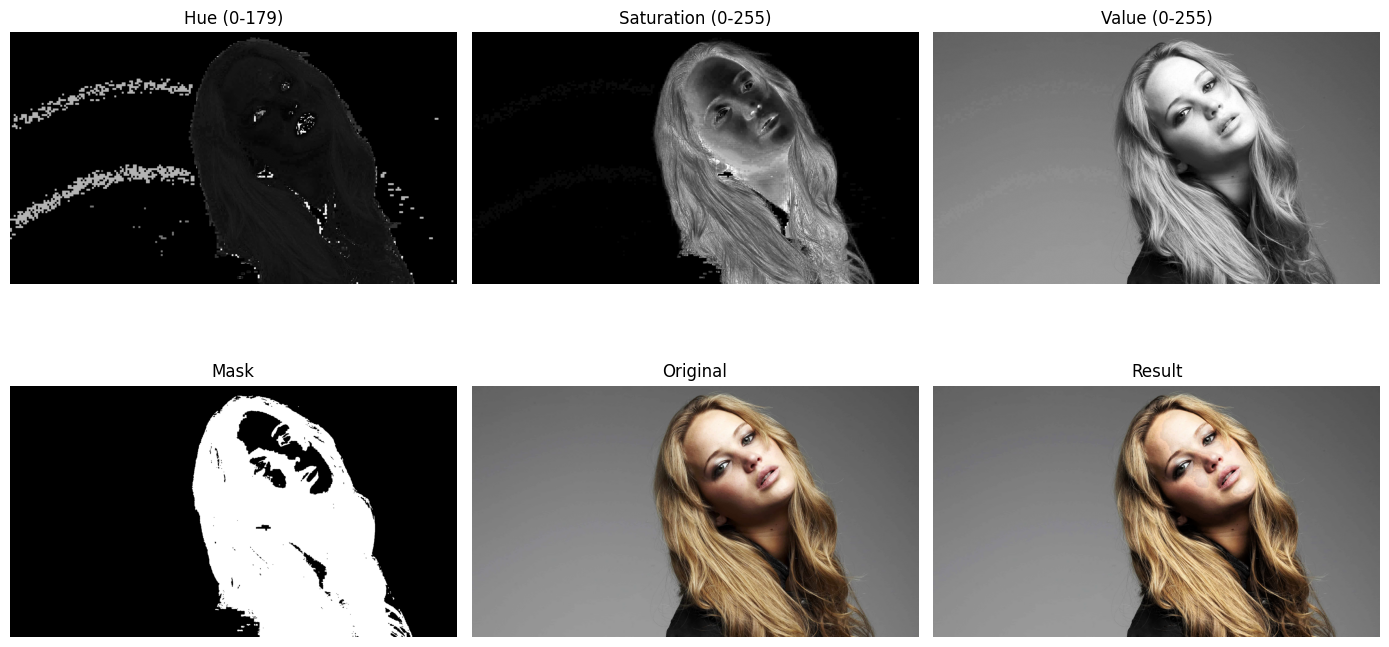

In [ ]:
# Visualize Results
rgb_original = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
rgb_result   = cv2.cvtColor(bgr_result, cv2.COLOR_BGR2RGB)

# Display Hue, Saturation, and Value
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes[0,0].imshow(hue_plane, cmap="gray");
axes[0,0].set_title("Hue (0-179)");
axes[0,0].axis("off")

axes[0,1].imshow(saturation_plane, cmap="gray");
axes[0,1].set_title("Saturation (0-255)");
axes[0,1].axis("off")

axes[0,2].imshow(value_plane, cmap="gray");
axes[0,2].set_title("Value (0-255)");
axes[0,2].axis("off")

# Display Mask, Original image, Result Image
# Result - Foreground histogram-equalized
axes[1,0].imshow(foreground_mask, cmap="gray");
axes[1,0].set_title("Mask");
axes[1,0].axis("off")

axes[1,1].imshow(rgb_original);
axes[1,1].set_title("Original");
axes[1,1].axis("off")

axes[1,2].imshow(rgb_result);
axes[1,2].set_title("Result");
axes[1,2].axis("off")
plt.tight_layout();
plt.show()

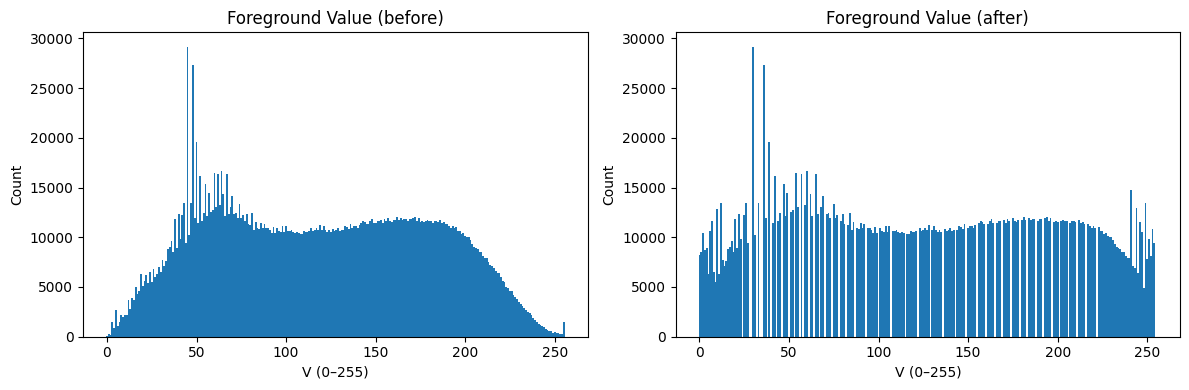

In [ ]:
# Display Histograms (before vs after on foreground)
foreground_values_after = equalized_value_plane[foreground_mask == 255]
foreground_hist_counts_after = cv2.calcHist(
    images = [equalized_value_plane], channels=[0],
    mask = foreground_mask, histSize=[256], ranges=[0, 256]
).flatten()

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.bar(np.arange(256), foreground_hist_counts, width=1)
ax1.set_title("Foreground Value (before)")
ax2.bar(np.arange(256), foreground_hist_counts_after, width=1);
ax2.set_title("Foreground Value (after)")
for ax in (ax1, ax2):
    ax.set_xlabel("V (0–255)");
    ax.set_ylabel("Count")
plt.tight_layout();
plt.show()

# Question 06

In [ ]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load image as grayscale
image_path = "einstein.png"
grayscale_image: np.ndarray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

In [ ]:
# Helper to map any array to 8-bit for display
def normalize_for_display(array: np.ndarray) -> np.ndarray:
    array_abs = np.abs(array)
    array_norm = array_abs / (array_abs.max() + 1e-9)
    return (255 * array_norm).astype(np.uint8)

# Standard 3×3 Sobel kernels (X and Y)
sobel_kernel_x: np.ndarray = np.array([[1, 0, -1],
                                       [2, 0, -2],
                                       [1, 0, -1]], dtype=np.float32)

# Transpose of sobel_kernel_x
sobel_kernel_y: np.ndarray = sobel_kernel_x.T

In [ ]:
# (a) Sobel using existing filter2D

gradient_x_filter2D: np.ndarray = cv2.filter2D(grayscale_image, cv2.CV_64F, sobel_kernel_x,
                                               borderType=cv2.BORDER_REPLICATE)

gradient_y_filter2D: np.ndarray = cv2.filter2D(grayscale_image, cv2.CV_64F, sobel_kernel_y,
                                               borderType=cv2.BORDER_REPLICATE)

magnitude_filter2D:  np.ndarray = np.hypot(gradient_x_filter2D, gradient_y_filter2D)

In [ ]:
# (b) Sobel convolution for self written code

def convolve2d_simple(image_gray: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """Slide a kernel over the image and sum window*kernel (edge-padded)."""
    kernel_height, kernel_width = kernel.shape
    pad_y, pad_x = kernel_height // 2, kernel_width // 2

    # pad image so the output has the same size
    padded = np.pad(image_gray, ((pad_y, pad_y), (pad_x, pad_x)), mode="edge")

    output = np.zeros_like(image_gray, dtype=np.float32)
    height, width = image_gray.shape

    for y in range(height):
        for x in range(width):
            window = padded[y:y + kernel_height, x:x + kernel_width]
            output[y, x] = np.sum(window * kernel)  # correlation (no kernel flip)

    return output

# Apply manual convolution with Sobel kernels
gradient_x_manual: np.ndarray = convolve2d_simple(grayscale_image, sobel_kernel_x)
gradient_y_manual: np.ndarray = convolve2d_simple(grayscale_image, sobel_kernel_y)
magnitude_manual:  np.ndarray = np.hypot(gradient_x_manual, gradient_y_manual)

In [ ]:
# (c) Separable Sobel using [1,2,1]^T * [1,0,-1]

smoothing_kernel_1d:  np.ndarray = np.array([1, 2, 1], dtype=np.float32)
derivative_kernel_1d: np.ndarray = np.array([1, 0, -1], dtype=np.float32)

# Gx: horizontal derivative, vertical smoothing
gradient_x_separable: np.ndarray = cv2.sepFilter2D(grayscale_image, cv2.CV_64F,
                                                   derivative_kernel_1d, smoothing_kernel_1d)

# Gy: vertical derivative, horizontal smoothing
gradient_y_separable: np.ndarray = cv2.sepFilter2D(grayscale_image, cv2.CV_64F,
                                                   smoothing_kernel_1d, derivative_kernel_1d)
magnitude_separable:  np.ndarray = np.hypot(gradient_x_separable, gradient_y_separable)

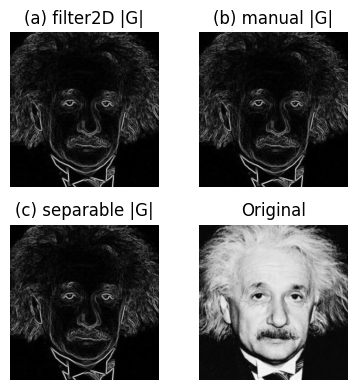

In [ ]:
# Show results (Gradient Magnitudes)
titles = ["(a) filter2D |G|", "(b) manual |G|", "(c) separable |G|", "Original"]
images = [normalize_for_display(magnitude_filter2D),
          normalize_for_display(magnitude_manual),
          normalize_for_display(magnitude_separable),
          grayscale_image.astype(np.uint8)]

plt.figure(figsize=(4,4))
for idx, (title, img) in enumerate(zip(titles, images), start=1):
    plt.subplot(2, 2, idx)
    plt.imshow(img, cmap="gray")
    plt.title(title);
    plt.axis("off")
plt.tight_layout();
plt.show()

# Question 07

In [17]:
# Imports
import cv2
import numpy as np

In [18]:
# function to zoom image
def zoom_image(input_image: np.ndarray, scaling_factor: float, interpolation_method: str = "nearest") -> np.ndarray:

    # Validate inputs
    if not (0 < scaling_factor <= 10):
        raise ValueError("scaling_factor must be in (0, 10].")
    if interpolation_method not in {"nearest", "bilinear"}:
        raise ValueError("interpolation_method must be 'nearest' or 'bilinear'.")

    # Prepare data
    # Work in float for math; unify to (H, W, C) even for grayscale
    source_image = input_image.astype(np.float32)
    if source_image.ndim == 2:
        source_image = source_image[..., None]

    input_height, input_width, num_channels = source_image.shape
    output_height = int(round(input_height * scaling_factor))
    output_width  = int(round(input_width  * scaling_factor))

    # Map output pixel centers to source coordinates (half-pixel rule)
    # This gives symmetric, standard resampling behavior.
    source_y_coords = (np.arange(output_height, dtype=np.float32) + 0.5) / scaling_factor - 0.5
    source_x_coords = (np.arange(output_width,  dtype=np.float32) + 0.5) / scaling_factor - 0.5

    # Keep coordinates inside valid range
    source_y_coords = np.clip(source_y_coords, 0, input_height - 1)
    source_x_coords = np.clip(source_x_coords, 0, input_width  - 1)

    # Interpolate
    if interpolation_method == "nearest":
        # Pick the closest source pixel
        y_indices_nearest = np.rint(source_y_coords).astype(np.int32)
        x_indices_nearest = np.rint(source_x_coords).astype(np.int32)
        output_float = source_image[y_indices_nearest[:, None], x_indices_nearest[None, :], :]

    else:  # "bilinear"
        # Neighbor integer coordinates
        y0 = np.floor(source_y_coords).astype(np.int32)
        x0 = np.floor(source_x_coords).astype(np.int32)
        y1 = np.clip(y0 + 1, 0, input_height - 1)
        x1 = np.clip(x0 + 1, 0, input_width  - 1)

        # Fractional weights in [0,1]
        vertical_weights   = (source_y_coords - y0).reshape(-1, 1, 1)  # (Hout,1,1)
        horizontal_weights = (source_x_coords - x0).reshape( 1,-1, 1)  # (1,Wout,1)

        # Sample the 4 neighbors (broadcasted gathers)
        top_left     = source_image[y0[:, None], x0[None, :], :]
        top_right    = source_image[y0[:, None], x1[None, :], :]
        bottom_left  = source_image[y1[:, None], x0[None, :], :]
        bottom_right = source_image[y1[:, None], x1[None, :], :]

        # Horizontal then vertical linear blends
        top_row    = (1 - horizontal_weights) * top_left  + horizontal_weights * top_right
        bottom_row = (1 - horizontal_weights) * bottom_left + horizontal_weights * bottom_right
        output_float = (1 - vertical_weights) * top_row + vertical_weights * bottom_row

    # clip, cast, and squeeze grayscale back to (H,W)
    output_uint8 = np.clip(output_float, 0, 255).astype(np.uint8)
    return output_uint8[..., 0] if output_uint8.shape[2] == 1 else output_uint8

In [19]:
# function to get normalize ssd
def normalized_ssd(image_a: np.ndarray, image_b: np.ndarray) -> float:
    """Mean squared difference normalized by 255^2 → value in [0, 1]."""
    if image_a.shape != image_b.shape:
        raise ValueError("Images must have the same shape for SSD.")
    diff = image_a.astype(np.float32) - image_b.astype(np.float32)
    return float(np.mean(diff**2) / (255.0**2))

In [20]:
# Testing Images
original_bgr = cv2.imread("im01.png")
small_bgr    = cv2.imread("im01small.png")

scale_factor = 4.0
up_nearest  = zoom_image(small_bgr, scale_factor, interpolation_method="nearest")
up_bilinear = zoom_image(small_bgr, scale_factor, interpolation_method="bilinear")

print("Normalized SSD (nearest): ", normalized_ssd(original_bgr, up_nearest))
print("Normalized SSD (bilinear):", normalized_ssd(original_bgr, up_bilinear))

Normalized SSD (nearest):  0.002095641102641821
Normalized SSD (bilinear): 0.0017704952042549849


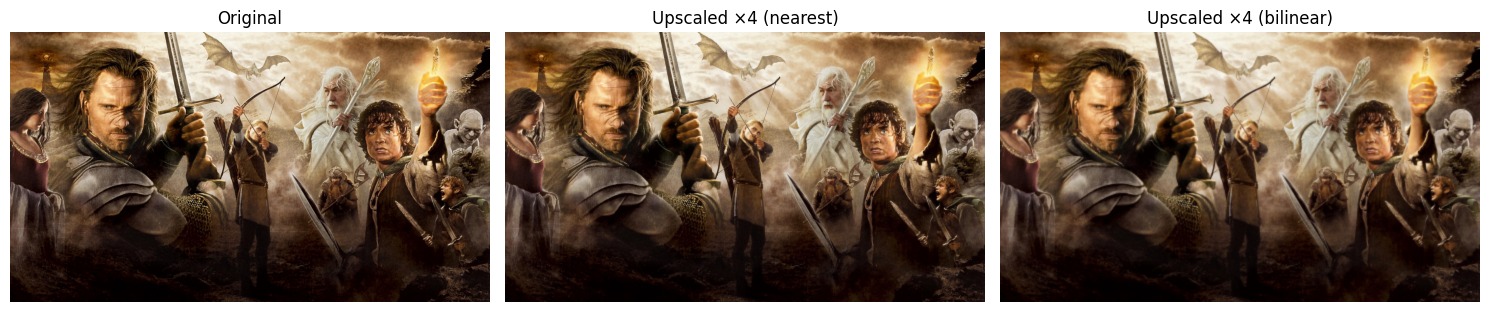

In [21]:
# Displaying Original and Upscaled Images
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB))
plt.title("Original");
plt.axis("off")

plt.subplot(1,3,2);
plt.imshow(cv2.cvtColor(up_nearest,cv2.COLOR_BGR2RGB))
plt.title("Upscaled ×4 (nearest)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(up_bilinear, cv2.COLOR_BGR2RGB))
plt.title("Upscaled ×4 (bilinear)")
plt.axis("off")
plt.tight_layout()
plt.show()